## Question 3: Markov chain Monte Carlo

- Apply the simple random-walk Metropolis-Hasting and Metropolis Adjusted Langevin Algorithm (MALA)
to an unnormalized distribution.
- Provide the histogram of the samples and the trace plot of the samples to see how the chain moved
around.
- Compare the performance of these approaches.

Some references:
- https://www.aptech.com/resources/tutorials/bayesian-fundamentals/metropolis-hastings-sampler/
- https://stephens999.github.io/fiveMinuteStats/MH_intro.html
- https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/MetropolisAdjustedLangevinAlgorithm

In [26]:
## Metropolis Hastings
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns


def matropolis_sampling(x, log_prob, n_step, n_sample_out, var):

    def _sample_next(x, var):
        # x: numpy 1d 
        return np.random.randn(x.shape[0]) * np.sqrt(var) + x
    

    res = []
    for _ in range(n_step):
        x_next = _sample_next(x, var)
        accept_prob_log = min(0, log_prob(x_next) - log_prob(x))
        if np.log(np.random.rand()) < accept_prob_log:
            x = x_next
        res.append(x)
    return np.stack(res, axis = 0)[-n_sample_out:]
    

def log_dist_prob(x): # normal gaussian distribution
    return -0.5 * (x @ x)  # equivalent to -0.5 * x.T @ x


In [12]:
x = np.random.randn(2)
log_dist_prob(x)

-5.277883039889793

In [31]:
out = matropolis_sampling(np.random.randn(1), log_dist_prob, 10000, 1000, 0.2)

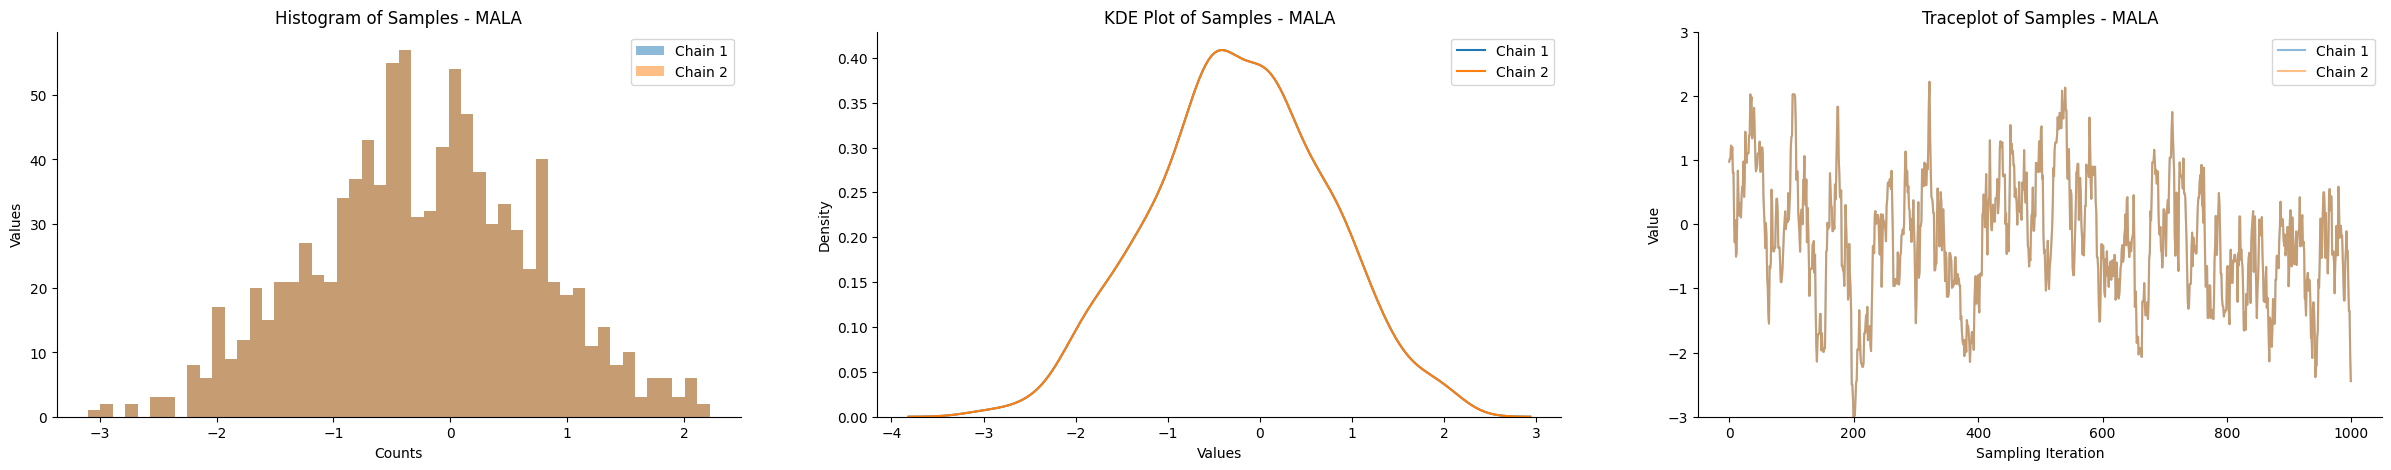

In [32]:
chain_1_MALA_1d = out
chain_2_MALA_1d = out
fig, ax = plt.subplots(1,3,figsize=(30,5))
ax[0].hist(chain_1_MALA_1d, bins=50, alpha=0.5, label='Chain 1')
ax[0].hist(chain_2_MALA_1d, bins=50, alpha=0.5, label='Chain 2')
ax[0].legend()
ax[0].set_xlabel('Counts')
ax[0].set_ylabel('Values')

# Assuming ax is your subplot axes
sns.kdeplot(chain_1_MALA_1d.reshape(-1), ax=ax[1], label='Chain 1')
sns.kdeplot(chain_2_MALA_1d.reshape(-1), ax=ax[1], label='Chain 2')

# Set labels and legend for the KDE plot
ax[1].set_xlabel('Values')
ax[1].set_ylabel('Density')
ax[1].legend()


ax[2].plot(chain_1_MALA_1d, alpha=0.5, label='Chain 1')
ax[2].plot(chain_2_MALA_1d, alpha=0.5, label='Chain 2')
ax[2].set_ylim([-3,3])
ax[2].legend()
ax[2].set_xlabel('Sampling Iteration')
ax[2].set_ylabel('Value')

ax[0].set_title('Histogram of Samples - MALA')
ax[1].set_title('KDE Plot of Samples - MALA')
ax[2].set_title('Traceplot of Samples - MALA')

ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
ax[2].spines[['right', 'top']].set_visible(False)

plt.show()

In [ ]:
## MALA

import numpy as np
import torch
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def dist_prob(x):
    term1 = -((x**4).sum())
    term2 = -0.5 * (torch.outer(x,x)-torch.diag(x**2)).sum()
    return torch.exp(term1+term2)


def q_y_x(model, step, y, x):
    x.requires_grad_()
    out = torch.log(model(x))
    grad = torch.autograd.grad(out, x)[0]
    norm = -torch.norm((y - x.detach() - step / 2 * grad) / (2 * step), 2)**2
    return torch.exp(norm)


def accept_prob(model, z_new, z, step):
    left = model(z_new) / model(z)
    right = q_y_x(model, step, z, z_new) / q_y_x(model,step, z_new, z)
    prob = left * right
    return min(1, prob.item())

def mala_sample(x, model, n_steps = 40000, n_sample_out = 20000, step = 0.2 ):
    res = []
    
    z  = torch.clone(x)

    for step in tqdm.tqdm(range(n_steps)):
        z.requires_grad_()
        out = torch.log(model(z))
        print("out", out, step)
        grad = torch.autograd.grad(out, z)[0]
        print("grad", grad, step)
        z_new = z.detach() + step / 2 * grad + torch.randn(z.size(0)) * np.sqrt(step)
        print("z_new", z_new, step)
        a_prob = accept_prob(model, z_new, z, step)
        print("a_prob", a_prob, step)
        if torch.rand(1).item() < a_prob:
            z = z_new
        res.append(z.detach().numpy())
        print("z end", z_new, step)
    return np.stack(res, axis = 0)[-n_sample_out:]

out = mala_sample(torch.randn(1), dist_prob, n_steps=10000, n_sample_out=5000, step = 0.001)

  1%|          | 81/10000 [00:00<00:24, 406.66it/s]

out tensor(-0.8414, grad_fn=<LogBackward0>) 0
grad tensor([3.5142]) 0
z_new tensor([-0.9578]) 0
a_prob 1 0
z end tensor([-0.9578], requires_grad=True) 0
out tensor(-0.8414, grad_fn=<LogBackward0>) 1
grad tensor([3.5142]) 1
z_new tensor([-0.0612]) 1
a_prob 1 1
z end tensor([-0.0612], requires_grad=True) 1
out tensor(-1.4067e-05, grad_fn=<LogBackward0>) 2
grad tensor([0.0009]) 2
z_new tensor([2.4036]) 2
a_prob 0.0 2
z end tensor([2.4036], requires_grad=True) 2
out tensor(-1.4067e-05, grad_fn=<LogBackward0>) 3
grad tensor([0.0009]) 3
z_new tensor([0.6320]) 3
a_prob 0.8479520082473755 3
z end tensor([0.6320], requires_grad=True) 3
out tensor(-0.1595, grad_fn=<LogBackward0>) 4
grad tensor([-1.0096]) 4
z_new tensor([-2.0258]) 4
a_prob 1.2303488406211576e-35 4
z end tensor([-2.0258], requires_grad=True) 4
out tensor(-0.1595, grad_fn=<LogBackward0>) 5
grad tensor([-1.0096]) 5
z_new tensor([-1.9099]) 5
a_prob 5.256543827061102e-26 5
z end tensor([-1.9099], requires_grad=True) 5
out tensor(-0.15

  1%|▏         | 125/10000 [00:00<00:23, 415.80it/s]

out tensor(nan, grad_fn=<LogBackward0>) 81
grad tensor([nan]) 81
z_new tensor([nan]) 81
a_prob 1 81
z end tensor([nan], requires_grad=True) 81
out tensor(nan, grad_fn=<LogBackward0>) 82
grad tensor([nan]) 82
z_new tensor([nan]) 82
a_prob 1 82
z end tensor([nan], requires_grad=True) 82
out tensor(nan, grad_fn=<LogBackward0>) 83
grad tensor([nan]) 83
z_new tensor([nan]) 83
a_prob 1 83
z end tensor([nan], requires_grad=True) 83
out tensor(nan, grad_fn=<LogBackward0>) 84
grad tensor([nan]) 84
z_new tensor([nan]) 84
a_prob 1 84
z end tensor([nan], requires_grad=True) 84
out tensor(nan, grad_fn=<LogBackward0>) 85
grad tensor([nan]) 85
z_new tensor([nan]) 85
a_prob 1 85
z end tensor([nan], requires_grad=True) 85
out tensor(nan, grad_fn=<LogBackward0>) 86
grad tensor([nan]) 86
z_new tensor([nan]) 86
a_prob 1 86
z end tensor([nan], requires_grad=True) 86
out tensor(nan, grad_fn=<LogBackward0>) 87
grad tensor([nan]) 87
z_new tensor([nan]) 87
a_prob 1 87
z end tensor([nan], requires_grad=True) 87

  2%|▏         | 210/10000 [00:00<00:23, 414.03it/s]

a_prob 1 165
z end tensor([nan], requires_grad=True) 165
out tensor(nan, grad_fn=<LogBackward0>) 166
grad tensor([nan]) 166
z_new tensor([nan]) 166
a_prob 1 166
z end tensor([nan], requires_grad=True) 166
out tensor(nan, grad_fn=<LogBackward0>) 167
grad tensor([nan]) 167
z_new tensor([nan]) 167
a_prob 1 167
z end tensor([nan], requires_grad=True) 167
out tensor(nan, grad_fn=<LogBackward0>) 168
grad tensor([nan]) 168
z_new tensor([nan]) 168
a_prob 1 168
z end tensor([nan], requires_grad=True) 168
out tensor(nan, grad_fn=<LogBackward0>) 169
grad tensor([nan]) 169
z_new tensor([nan]) 169
a_prob 1 169
z end tensor([nan], requires_grad=True) 169
out tensor(nan, grad_fn=<LogBackward0>) 170
grad tensor([nan]) 170
z_new tensor([nan]) 170
a_prob 1 170
z end tensor([nan], requires_grad=True) 170
out tensor(nan, grad_fn=<LogBackward0>) 171
grad tensor([nan]) 171
z_new tensor([nan]) 171
a_prob 1 171
z end tensor([nan], requires_grad=True) 171
out tensor(nan, grad_fn=<LogBackward0>) 172
grad tensor

  3%|▎         | 294/10000 [00:00<00:23, 412.93it/s]

a_prob 1 249
z end tensor([nan], requires_grad=True) 249
out tensor(nan, grad_fn=<LogBackward0>) 250
grad tensor([nan]) 250
z_new tensor([nan]) 250
a_prob 1 250
z end tensor([nan], requires_grad=True) 250
out tensor(nan, grad_fn=<LogBackward0>) 251
grad tensor([nan]) 251
z_new tensor([nan]) 251
a_prob 1 251
z end tensor([nan], requires_grad=True) 251
out tensor(nan, grad_fn=<LogBackward0>) 252
grad tensor([nan]) 252
z_new tensor([nan]) 252
a_prob 1 252
z end tensor([nan], requires_grad=True) 252
out tensor(nan, grad_fn=<LogBackward0>) 253
grad tensor([nan]) 253
z_new tensor([nan]) 253
a_prob 1 253
z end tensor([nan], requires_grad=True) 253
out tensor(nan, grad_fn=<LogBackward0>) 254
grad tensor([nan]) 254
z_new tensor([nan]) 254
a_prob 1 254
z end tensor([nan], requires_grad=True) 254
out tensor(nan, grad_fn=<LogBackward0>) 255
grad tensor([nan]) 255
z_new tensor([nan]) 255
a_prob 1 255
z end tensor([nan], requires_grad=True) 255
out tensor(nan, grad_fn=<LogBackward0>) 256
grad tensor

  4%|▍         | 378/10000 [00:00<00:23, 414.15it/s]

tensor([nan]) 333
a_prob 1 333
z end tensor([nan], requires_grad=True) 333
out tensor(nan, grad_fn=<LogBackward0>) 334
grad tensor([nan]) 334
z_new tensor([nan]) 334
a_prob 1 334
z end tensor([nan], requires_grad=True) 334
out tensor(nan, grad_fn=<LogBackward0>) 335
grad tensor([nan]) 335
z_new tensor([nan]) 335
a_prob 1 335
z end tensor([nan], requires_grad=True) 335
out tensor(nan, grad_fn=<LogBackward0>) 336
grad tensor([nan]) 336
z_new tensor([nan]) 336
a_prob 1 336
z end tensor([nan], requires_grad=True) 336
out tensor(nan, grad_fn=<LogBackward0>) 337
grad tensor([nan]) 337
z_new tensor([nan]) 337
a_prob 1 337
z end tensor([nan], requires_grad=True) 337
out tensor(nan, grad_fn=<LogBackward0>) 338
grad tensor([nan]) 338
z_new tensor([nan]) 338
a_prob 1 338
z end tensor([nan], requires_grad=True) 338
out tensor(nan, grad_fn=<LogBackward0>) 339
grad tensor([nan]) 339
z_new tensor([nan]) 339
a_prob 1 339
z end tensor([nan], requires_grad=True) 339
out tensor(nan, grad_fn=<LogBackward0

  5%|▍         | 463/10000 [00:01<00:22, 415.76it/s]

grad tensor([nan]) 417
z_new tensor([nan]) 417
a_prob 1 417
z end tensor([nan], requires_grad=True) 417
out tensor(nan, grad_fn=<LogBackward0>) 418
grad tensor([nan]) 418
z_new tensor([nan]) 418
a_prob 1 418
z end tensor([nan], requires_grad=True) 418
out tensor(nan, grad_fn=<LogBackward0>) 419
grad tensor([nan]) 419
z_new tensor([nan]) 419
a_prob 1 419
z end tensor([nan], requires_grad=True) 419
out tensor(nan, grad_fn=<LogBackward0>) 420
grad tensor([nan]) 420
z_new tensor([nan]) 420
a_prob 1 420
z end tensor([nan], requires_grad=True) 420
out tensor(nan, grad_fn=<LogBackward0>) 421
grad tensor([nan]) 421
z_new tensor([nan]) 421
a_prob 1 421
z end tensor([nan], requires_grad=True) 421
out tensor(nan, grad_fn=<LogBackward0>) 422
grad tensor([nan]) 422
z_new tensor([nan]) 422
a_prob 1 422
z end tensor([nan], requires_grad=True) 422
out tensor(nan, grad_fn=<LogBackward0>) 423
grad tensor([nan]) 423
z_new tensor([nan]) 423
a_prob 1 423
z end tensor([nan], requires_grad=True) 423
out tens

  5%|▌         | 548/10000 [00:01<00:22, 415.03it/s]

a_prob 1 500
z end tensor([nan], requires_grad=True) 500
out tensor(nan, grad_fn=<LogBackward0>) 501
grad tensor([nan]) 501
z_new tensor([nan]) 501
a_prob 1 501
z end tensor([nan], requires_grad=True) 501
out tensor(nan, grad_fn=<LogBackward0>) 502
grad tensor([nan]) 502
z_new tensor([nan]) 502
a_prob 1 502
z end tensor([nan], requires_grad=True) 502
out tensor(nan, grad_fn=<LogBackward0>) 503
grad tensor([nan]) 503
z_new tensor([nan]) 503
a_prob 1 503
z end tensor([nan], requires_grad=True) 503
out tensor(nan, grad_fn=<LogBackward0>) 504
grad tensor([nan]) 504
z_new tensor([nan]) 504
a_prob 1 504
z end tensor([nan], requires_grad=True) 504
out tensor(nan, grad_fn=<LogBackward0>) 505
grad tensor([nan]) 505
z_new tensor([nan]) 505
a_prob 1 505
z end tensor([nan], requires_grad=True) 505
out tensor(nan, grad_fn=<LogBackward0>) 506
grad tensor([nan]) 506
z_new tensor([nan]) 506
a_prob 1 506
z end tensor([nan], requires_grad=True) 506
out tensor(nan, grad_fn=<LogBackward0>) 507
grad tensor

  6%|▋         | 632/10000 [00:01<00:22, 414.67it/s]

grad tensor([nan]) 585
z_new tensor([nan]) 585
a_prob 1 585
z end tensor([nan], requires_grad=True) 585
out tensor(nan, grad_fn=<LogBackward0>) 586
grad tensor([nan]) 586
z_new tensor([nan]) 586
a_prob 1 586
z end tensor([nan], requires_grad=True) 586
out tensor(nan, grad_fn=<LogBackward0>) 587
grad tensor([nan]) 587
z_new tensor([nan]) 587
a_prob 1 587
z end tensor([nan], requires_grad=True) 587
out tensor(nan, grad_fn=<LogBackward0>) 588
grad tensor([nan]) 588
z_new tensor([nan]) 588
a_prob 1 588
z end tensor([nan], requires_grad=True) 588
out tensor(nan, grad_fn=<LogBackward0>) 589
grad tensor([nan]) 589
z_new tensor([nan]) 589
a_prob 1 589
z end tensor([nan], requires_grad=True) 589
out tensor(nan, grad_fn=<LogBackward0>) 590
grad tensor([nan]) 590
z_new tensor([nan]) 590
a_prob 1 590
z end tensor([nan], requires_grad=True) 590
out tensor(nan, grad_fn=<LogBackward0>) 591
grad tensor([nan]) 591
z_new tensor([nan]) 591
a_prob 1 591
z end tensor([nan], requires_grad=True) 591
out tens

  7%|▋         | 710/10000 [00:01<00:22, 412.67it/s]


out tensor(nan, grad_fn=<LogBackward0>) 670
grad tensor([nan]) 670
z_new tensor([nan]) 670
a_prob 1 670
z end tensor([nan], requires_grad=True) 670
out tensor(nan, grad_fn=<LogBackward0>) 671
grad tensor([nan]) 671
z_new tensor([nan]) 671
a_prob 1 671
z end tensor([nan], requires_grad=True) 671
out tensor(nan, grad_fn=<LogBackward0>) 672
grad tensor([nan]) 672
z_new tensor([nan]) 672
a_prob 1 672
z end tensor([nan], requires_grad=True) 672
out tensor(nan, grad_fn=<LogBackward0>) 673
grad tensor([nan]) 673
z_new tensor([nan]) 673
a_prob 1 673
z end tensor([nan], requires_grad=True) 673
out tensor(nan, grad_fn=<LogBackward0>) 674
grad tensor([nan]) 674
z_new tensor([nan]) 674
a_prob 1 674
z end tensor([nan], requires_grad=True) 674
out tensor(nan, grad_fn=<LogBackward0>) 675
grad tensor([nan]) 675
z_new tensor([nan]) 675
a_prob 1 675
z end tensor([nan], requires_grad=True) 675
out tensor(nan, grad_fn=<LogBackward0>) 676
grad tensor([nan]) 676
z_new tensor([nan]) 676
a_prob 1 676
z end te

KeyboardInterrupt: 

In [ ]:
## MALA

### NAN error (watch out exponential)
import numpy as np
import torch
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def dist_prob(x):
    term1 = -((x**4).sum())
    term2 = -0.5 * (torch.outer(x,x)-torch.diag(x**2)).sum()
    return torch.exp(term1+term2)


def q_y_x(model, step, y, x):
    x.requires_grad_()
    out = torch.log(model(x))
    grad = torch.autograd.grad(out, x)[0]
    norm = -torch.norm((y - x.detach() - step / 2 * grad) / (2 * step), 2)**2
    return torch.exp(norm)


def accept_prob(model, z_new, z, step):
    left = model(z_new) / model(z)
    right = q_y_x(model, step, z, z_new) / q_y_x(model,step, z_new, z)
    prob = left * right
    return min(1, prob.item())

def mala_sample(x, model, n_steps = 40000, n_sample_out = 20000, step = 0.2 ):
    res = []
    
    z  = torch.clone(x)

    for step in tqdm.tqdm(range(n_steps)):
        z.requires_grad_()
        out = torch.log(model(z))
        print("out", out, step)
        grad = torch.autograd.grad(out, z)[0]
        print("grad", grad, step)
        z_new = z.detach() + step / 2 * grad + torch.randn(z.size(0)) * np.sqrt(step)
        print("z_new", z_new, step)
        a_prob = accept_prob(model, z_new, z, step)
        print("a_prob", a_prob, step)
        if torch.rand(1).item() < a_prob:
            z = z_new
        res.append(z.detach().numpy())
        print("z end", z_new, step)
    return np.stack(res, axis = 0)[-n_sample_out:]

out = mala_sample(torch.randn(1), dist_prob, n_steps=10000, n_sample_out=5000, step = 0.001)

In [ ]:
## MALA
import numpy as np
import torch
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# def log_dist_prob(x):
#     term1 = -((x**4).sum())
#     term2 = -0.5 * (torch.outer(x,x)-torch.diag(x**2)).sum()
#     return term1+term2


# def log_dist_prob(x):
#     return -0.5 * (x @ x)  # equivalent to -0.5 * x.T @ x


def log_q_y_x(model, step, y, x):
    x.requires_grad_()
    out = model(x)
    grad = torch.autograd.grad(out, x)[0]
    norm = -torch.norm((y - x.detach() - step / 2 * grad), 2)**2 / (4 * step)
    return norm


def log_accept_prob(model, z_new, z, step):
    left = model(z_new) -  model(z)
    right = log_q_y_x(model, step, z, z_new) - log_q_y_x(model,step, z_new, z)
    prob = left + right
    return min(0, prob)
    

def mala_sample(x, model, n_steps = 40000, n_sample_out = 20000, step = 0.2 ):
    res = []
    
    z  = torch.clone(x)
    pbar = tqdm.tqdm(range(n_steps))

    for _ in pbar:
        z.requires_grad_()
        out = model(z)
        grad = torch.autograd.grad(out, z)[0]
        z_new = z.detach() + step / 2 * grad + torch.randn(z.size(0)) * np.sqrt(step)
        a_log_prob = log_accept_prob(model, z_new, z, step)
        if torch.log(torch.rand(1)).item() < a_log_prob:
            z = z_new
        res.append(z.detach().numpy())
        pbar.set_description(f"z value {z}, a log prob: {a_log_prob}")
    return np.stack(res, axis = 0)[-n_sample_out:]

out = mala_sample(torch.randn(1), log_dist_prob, n_steps=20000, n_sample_out=5000, step = 0.1)

z value tensor([0.4845], requires_grad=True), a log prob: 0: 100%|██████████| 20000/20000 [01:04<00:00, 307.77it/s]                          


In [41]:
chain_1_MALA_1d = out
chain_2_MALA_1d = out

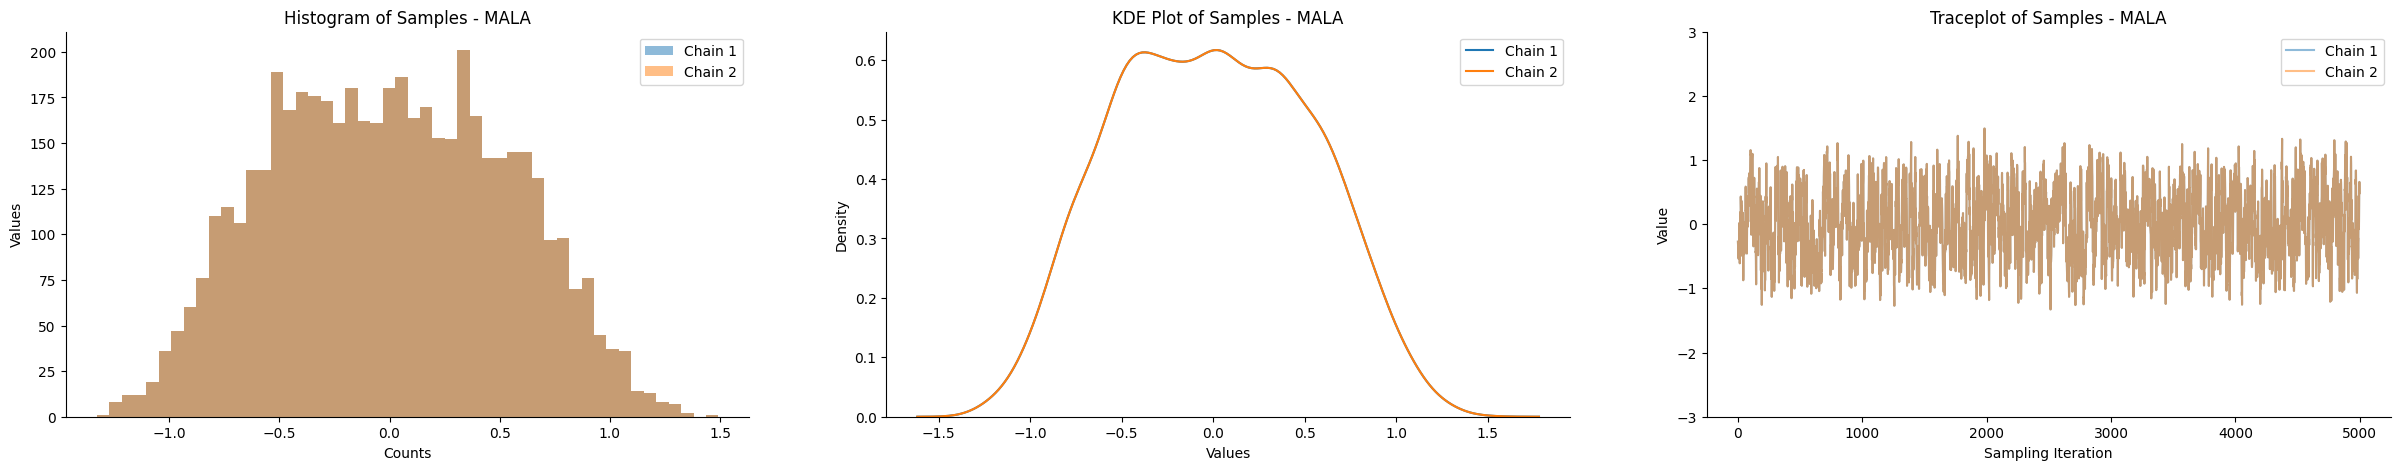

In [ ]:
chain_1_MALA_1d = out
chain_2_MALA_1d = out
fig, ax = plt.subplots(1,3,figsize=(30,5))
ax[0].hist(chain_1_MALA_1d, bins=50, alpha=0.5, label='Chain 1')
ax[0].hist(chain_2_MALA_1d, bins=50, alpha=0.5, label='Chain 2')
ax[0].legend()
ax[0].set_xlabel('Counts')
ax[0].set_ylabel('Values')

# Assuming ax is your subplot axes
sns.kdeplot(chain_1_MALA_1d.reshape(-1), ax=ax[1], label='Chain 1')
sns.kdeplot(chain_2_MALA_1d.reshape(-1), ax=ax[1], label='Chain 2')

# Set labels and legend for the KDE plot
ax[1].set_xlabel('Values')
ax[1].set_ylabel('Density')
ax[1].legend()


ax[2].plot(chain_1_MALA_1d, alpha=0.5, label='Chain 1')
ax[2].plot(chain_2_MALA_1d, alpha=0.5, label='Chain 2')
ax[2].set_ylim([-3,3])
ax[2].legend()
ax[2].set_xlabel('Sampling Iteration')
ax[2].set_ylabel('Value')

ax[0].set_title('Histogram of Samples - MALA')
ax[1].set_title('KDE Plot of Samples - MALA')
ax[2].set_title('Traceplot of Samples - MALA')

ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
ax[2].spines[['right', 'top']].set_visible(False)

plt.show()